In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib import pyplot
import sys
import seaborn as sns
from scipy import stats

plt.rcParams.update({
"font.size": 16,
"text.usetex": False,
#"font.family": "Times New Roman",
"mathtext.fontset": "stixsans"
})

In [67]:
def score(pt,D1,D2,gp):
    factor = D1-D2
    return((10**(D1/10))/(1+10**((factor/2 - pt - 2*gp)/10)))   
        
def points_match(x):
    if x > 0:
        return 1
    elif x < 0:
        return -5
    elif x == 0:
        return -2
    
def simulate_match(distA, distB, teamA, teamB):
    scoreA = distA.resample(1)
    scoreB = distB.resample(1)
        
    delta = scoreA - scoreB
    if np.abs(delta) < 1:
        return("draw")
    else:
        if delta > 0:
            return(teamA)
        else:
            return(teamB)

    
class world_cup:
    
    def __init__(self,groups,squad_distributions):
        self.groups = groups
        self.squad_distributions = squad_distributions
        
    def __simulate_match(self,distA, distB, teamA, teamB):
        scoreA = distA.resample(1)
        scoreB = distB.resample(1)
        
        delta = scoreA - scoreB
        if np.abs(delta) < 1:
            return("draw")
        else:
            if delta > 0:
                return(teamA)
            else:
                return(teamB)
            
    def __ponctuation(self,team,match_result):
        if team == match_result:
            return 3
        elif match_result == "draw":
            return 1
        else:
            return 0
  
    def simulate_group_stage(self):
        group_results = {g:[] for g in self.groups}
        points = {}
        
        for group in self.groups:
            teams = groups[group]
            points[group] = {team:0 for team in teams}
            
            k = 0
            for i in range(len(teams)):
                teamA = teams[i]
                for j in range(i+1,len(teams)):
                    teamB = teams[j]
                    distA = self.squad_distributions[teamA]
                    distB = self.squad_distributions[teamB]
                    match_result = self.__simulate_match(distA,distB,teamA,teamB)
                    group_results[group].append([teamA,teamB,match_result])
                    
                    points[group][teamA] += self.__ponctuation(teamA,match_result)
                    points[group][teamB] += self.__ponctuation(teamB,match_result)
                    
                    k = +1
        return(group_results,points)

Scores Table

Each match generates a score for both teams based on the result $r$ (V,E,D), difficulty of winning agains team $D_{team}$ and adversary $D_{adv}$ (based on the FIFA ranking) and goals balance $\Delta g$:
       $$Score = 10^{D_{team}/10}/(1+10^{[(D_{team}-D_{adv})/2 - r - 2\Delta g]/10})$$

In [3]:
D = pd.read_csv("difficulty.csv").astype({"squad":str,"rank":int,"difficulty":float})

regions = ["europe","southamerica","concacaf","africa","asia"]
scores_region, squads = {},{}

for region in regions:
    df = pd.read_csv(f"qualifiers_{region}.csv").dropna().astype({"Team_1":str,"Goals_1":int,"Goals_2":int,"Team_2":str})
    df["gp_1"] = df.apply(lambda row: row.Goals_1 - row.Goals_2, axis=1) 
    df["gp_2"] = df.apply(lambda row: row.Goals_2 - row.Goals_1, axis=1) 

    df["pt_1"] = df["gp_1"].apply(points_match)
    df["pt_2"] = df["gp_2"].apply(points_match)

    df["D_1"] = df["Team_1"].map({x:y for x,y in zip(D["squad"],D["difficulty"])})
    df["D_2"] = df["Team_2"].map({x:y for x,y in zip(D["squad"],D["difficulty"])})
    df.dropna(inplace=True)

    df["scores_1"] = df.apply(lambda row: score(row.pt_1, row.D_1, row.D_2, row.gp_1), axis=1)
    df["scores_2"] = df.apply(lambda row: score(row.pt_2, row.D_2, row.D_1, row.gp_2), axis=1)
    
    squads[region] = pd.unique(df[['Team_1', 'Team_2']].values.ravel('K'))
    scores_region[region] = df
    
scores_region["concacaf"]

,Team_1,Goals_1,Goals_2,Team_2,gp_1,gp_2,pt_1,pt_2,D_1,D_2,scores_1,scores_2
0,Canada,1,1,Honduras,0,0,-2,-2,5.31,3.09,1.114825,0.914522
1,Panama,0,0,Costa Rica,0,0,-2,-2,4.26,5.68,1.136836,1.290227
2,Mexico,2,1,Jamaica,1,-1,1,-5,7.49,4.08,3.220408,0.583547
3,El Salvador,0,0,USA,0,0,-2,-2,3.46,7.26,1.096330,1.540241
4,Jamaica,0,3,Panama,-3,3,-5,1,4.08,4.26,0.191927,2.215543
...,...,...,...,...,...,...,...,...,...,...,...,...
57,Qatar,1,0,Honduras,1,-1,1,-5,4.86,3.09,1.896576,0.400370
58,Qatar,2,0,Guatemala,2,-2,1,-5,4.86,1.23,2.068494,0.213066
59,Guatemala,1,2,Honduras,-1,1,-5,1,1.23,3.09,0.263071,1.256759
60,Guatemala,4,0,El Salvador,4,-4,1,-5,1.23,3.46,1.209596,0.082790


# Score Distribution

Based on the score's table, we assemble a score distribution using a gaussian kernel density estimator.

In [72]:
score_dens = {}
scores_squad = {}
squad_distribution = {} 

for region in regions:

    for squad in squads[region]:
        home = scores_region[region][scores_region[region]["Team_1"] == squad]["scores_1"]
        away = scores_region[region][scores_region[region]["Team_2"] == squad]["scores_2"]
        scores_squad[squad] = pd.concat([home,away])
        squad_distribution[squad] = stats.gaussian_kde(scores_squad[squad],bw_method=0.5)

# Matches

To simulate a match, scores are sampled from distributions. The highest score wins and if the difference of scores is below 1, it's a draw

Text(0.5, 1.0, '1000 matches results')

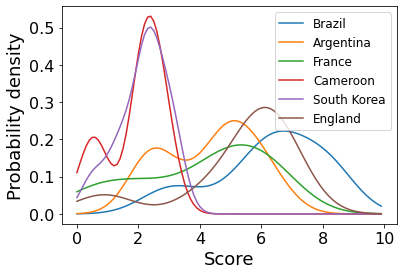

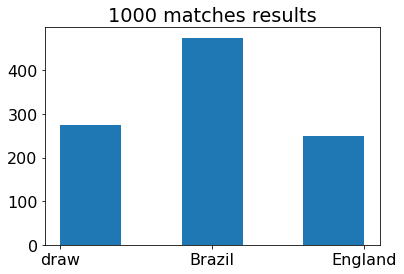

In [81]:
#exemplos de distribuiçoes
fig, ax = plt.subplots(1,1)

counts = {}
sq_list = ["Brazil","Argentina","France","Cameroon","South Korea","England"]

for squad in ["Brazil","Argentina","France","Cameroon","South Korea","England"]:
    dist = stats.gaussian_kde(scores_squad[squad],bw_method=0.5)
    
    x = np.arange(0,10,0.1)
    y = dist.pdf(x)

    ax.plot(x,y,label=squad)
    ax.set_ylabel("Probability density",size=18)
    ax.set_xlabel("Score",size=18)
    ax.legend(fontsize=12)
    
    adversaries = [sq for sq in sq_list if sq != squad]
    
    for adv in adversaries:
        dist_adv = stats.gaussian_kde(scores_squad[adv],bw_method=0.5)

        n_matches = 1000
        count = []
        for i in range(n_matches):
            match_result = simulate_match(dist,dist_adv,squad,adv)
            count.append(match_result)
        counts[squad+'x'+adv] = count
        
#resultado de 1000 confrontos
fig1, ax1 = plt.subplots(1,1)
ax1.hist(counts["BrazilxEngland"],bins=5,align="mid")
ax1.set_title("1000 matches results")


# Simulating the group stage of a World Cup

The method simulate_group_stage() simulates the group stage matches.

In [47]:
groups = {"A":["Qatar","Ecuador","Senegal","Netherlands"],"B":["England","Iran","USA","Wales"],"C":["Argentina","Saudi Arabia","Mexico","Poland"],"D":["France","Australia","Denmark","Tunisia"],"E":["Spain","Costa Rica","Germany","Japan"],"F":["Belgium","Canada","Morocco","Croatia"],"G":["Brazil","Serbia","Switzerland","Cameroon"],"H":["Portugal","Ghana","Uruguay","South Korea"]}

WorldCup = world_cup(groups,squad_distribution)
WorldCup.groups

results,points = WorldCup.simulate_group_stage()
results_df = pd.DataFrame(results)

results_df

,A,B,C,D,E,F,G,H
0,"[Qatar, Ecuador, draw]","[England, Iran, England]","[Argentina, Saudi Arabia, draw]","[France, Australia, Australia]","[Spain, Costa Rica, Spain]","[Belgium, Canada, Belgium]","[Brazil, Serbia, Brazil]","[Portugal, Ghana, Portugal]"
1,"[Qatar, Senegal, draw]","[England, USA, USA]","[Argentina, Mexico, Argentina]","[France, Denmark, draw]","[Spain, Germany, Germany]","[Belgium, Morocco, Belgium]","[Brazil, Switzerland, Switzerland]","[Portugal, Uruguay, draw]"
2,"[Qatar, Netherlands, Netherlands]","[England, Wales, England]","[Argentina, Poland, Argentina]","[France, Tunisia, France]","[Spain, Japan, Spain]","[Belgium, Croatia, Belgium]","[Brazil, Cameroon, Brazil]","[Portugal, South Korea, Portugal]"
3,"[Ecuador, Senegal, Senegal]","[Iran, USA, draw]","[Saudi Arabia, Mexico, draw]","[Australia, Denmark, Denmark]","[Costa Rica, Germany, Germany]","[Canada, Morocco, Morocco]","[Serbia, Switzerland, Switzerland]","[Ghana, Uruguay, Uruguay]"
4,"[Ecuador, Netherlands, Netherlands]","[Iran, Wales, Iran]","[Saudi Arabia, Poland, draw]","[Australia, Tunisia, Australia]","[Costa Rica, Japan, Japan]","[Canada, Croatia, Croatia]","[Serbia, Cameroon, Cameroon]","[Ghana, South Korea, draw]"
5,"[Senegal, Netherlands, Netherlands]","[USA, Wales, USA]","[Mexico, Poland, draw]","[Denmark, Tunisia, Denmark]","[Germany, Japan, Germany]","[Morocco, Croatia, Croatia]","[Switzerland, Cameroon, draw]","[Uruguay, South Korea, South Korea]"
